In [1]:
import os
import sys
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
sys.path.append(os.path.join(PROJ_ROOT, 'src'))

%matplotlib inline
%config InlineBackend.figure_format ='retina'

%load_ext autoreload
%autoreload 2

%aimport data, model, features, plot

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

from lightgbm import LGBMRegressor


from plot.plot import scatter_against_target_fig

from model.evaluation import score_rmse
import features.selection as feature_selection
import features.extraction as feature_extraction

In [2]:
from data.dataset import DataSet

traindf = DataSet.traindf
testdf = DataSet.testdf

X_train, y_train = traindf.drop(columns='target'), traindf.target
X_test, y_test = testdf.drop(columns='target'), testdf.target

In [3]:
print(f"train:\t{traindf.shape}\ntest:\t{testdf.shape}")

train:	(249876, 915)
test:	(242972, 915)


#### Note: for feature extraction see features.extraction package

In [4]:
print(f"Base line RMSE:\t\t{score_rmse(y_test, X_test.traff_mean):.3f}")

baseregressor = LGBMRegressor()
baseregressor.fit(X_train, y_train)
print(f"All features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test)): .3f}")

Base line RMSE:		9.393
All features RMSE:	 8.649


In [5]:
boruta_appearance, boruta_importance = feature_selection.boruta(X_train, y_train, iterations=20)

1. iteration is finished...  66.4s
2. iteration is finished...  65.0s
3. iteration is finished...  62.5s
4. iteration is finished...  60.4s
5. iteration is finished...  61.4s
6. iteration is finished...  61.0s
7. iteration is finished...  61.5s
8. iteration is finished...  62.0s
9. iteration is finished...  61.5s
10. iteration is finished...  62.4s
11. iteration is finished...  882.2s
12. iteration is finished...  62.7s
13. iteration is finished...  60.7s
14. iteration is finished...  62.5s
15. iteration is finished...  60.5s
16. iteration is finished...  60.5s
17. iteration is finished...  59.1s
18. iteration is finished...  59.5s
19. iteration is finished...  63.3s
20. iteration is finished...  62.2s


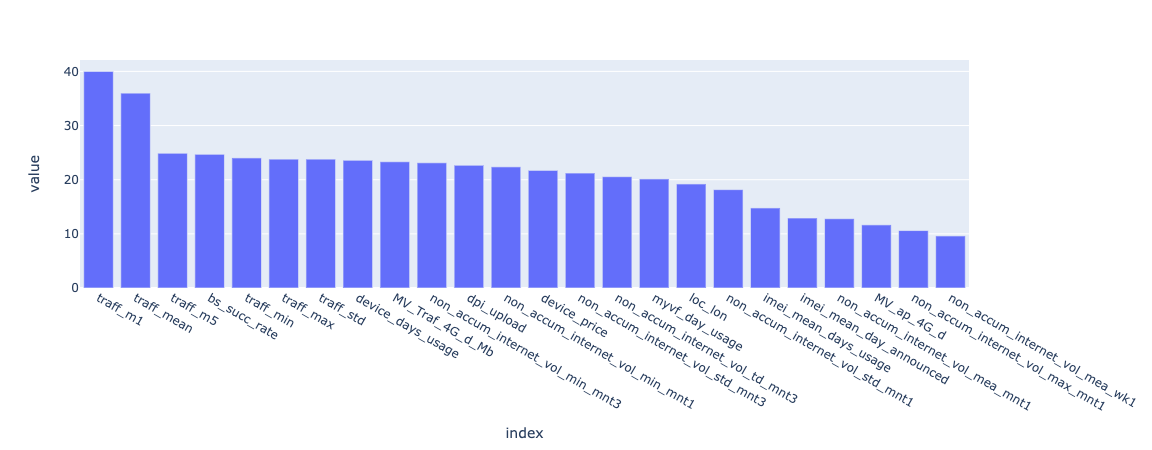

In [23]:
boruta_features = (boruta_appearance + boruta_importance)[boruta_appearance.where(lambda x: x >= 8).dropna().index]
fig = px.bar(boruta_features.sort_values(ascending=False))
fig.update_layout(showlegend=False)
fig.show()

In [24]:
baseregressor.fit(X_train[list(boruta_features.index)], y_train)
print(f"All boruta features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test[list(boruta_features.index)])): .3f}")

All boruta features RMSE:	 8.658


In [25]:
fig = scatter_against_target_fig(
    traindf[list(boruta_features.sort_values(ascending=False).index) + ['target']],
    sample=2000)
fig.update_layout(height=1600, showlegend=False)
# fig.show()
fig.write_html('scatter.html')

### Recursive feature elimination with cross-validation

In [26]:
from sklearn.feature_selection import RFECV

rfecv = RFECV(estimator=LGBMRegressor(), step=1, cv=5,
              scoring='neg_root_mean_squared_error',
              min_features_to_select=1)
rfecv.fit(traindf[boruta_features.index], traindf.target);

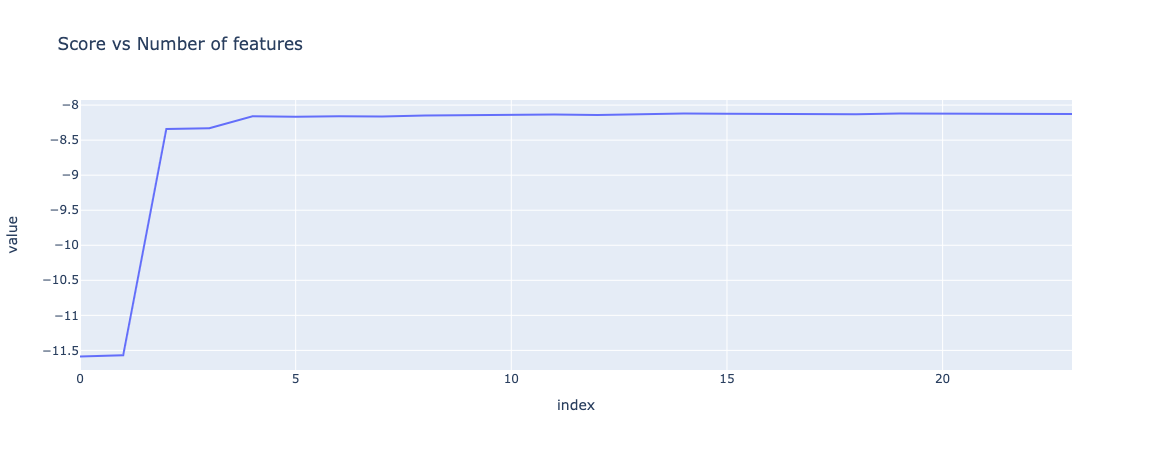

In [27]:
fig = px.line(rfecv.grid_scores_, title='Score vs Number of features',)
fig.update_layout(showlegend=False)

In [28]:
features_base = ['traff_m1', 'traff_mean', 'traff_m5']

In [66]:
baseregressor.fit(X_train[features_base], y_train)
print(f"Base features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test[features_base])): .3f}")

Base features RMSE:	 8.719


In [29]:
other_non_traffic_features = [x for x in boruta_features.index if not x.startswith('traff')]

In [36]:
result = feature_selection.grid_search(traindf, features_base, other_non_traffic_features,max_count_to_add=2)

1. iteration is finished...  18.0s
2. iteration is finished...  179.7s


In [49]:
result[0].sort_values(ascending=False)[:10]

(device_price,)                      -8.395244
(imei_mean_day_announced,)           -8.398678
(MV_ap_4G_d,)                        -8.398708
(dpi_upload,)                        -8.398805
(MV_Traf_4G_d_Mb,)                   -8.400750
(loc_lon,)                           -8.406778
(bs_succ_rate,)                      -8.408408
(non_accum_internet_vol_min_mnt3,)   -8.409487
(device_days_usage,)                 -8.410102
(non_accum_internet_vol_min_mnt1,)   -8.414260
dtype: float64

In [39]:
result[1].sort_values(ascending=False)[:10]

(device_price, imei_mean_day_announced)           -8.384625
(device_price, bs_succ_rate)                      -8.385003
(device_price, MV_ap_4G_d)                        -8.386369
(MV_ap_4G_d, imei_mean_day_announced)             -8.386847
(MV_Traf_4G_d_Mb, dpi_upload)                     -8.387030
(loc_lon, MV_ap_4G_d)                             -8.390063
(MV_ap_4G_d, dpi_upload)                          -8.390979
(loc_lon, imei_mean_day_announced)                -8.391984
(device_price, non_accum_internet_vol_min_mnt1)   -8.392998
(device_price, MV_Traf_4G_d_Mb)                   -8.393546
dtype: float64

In [57]:
pd.DataFrame((X_train[boruta_features.index].isnull().mean() * 100).apply(lambda x: round(x, 3))).sort_values(by=0)

,0
traff_std,0.000
traff_min,0.000
traff_mean,0.000
traff_m1,0.000
traff_m5,0.000
traff_max,0.000
MV_Traf_4G_d_Mb,0.294
dpi_upload,0.300
non_accum_internet_vol_td_mnt3,0.303
non_accum_internet_vol_std_mnt3,0.303


In [64]:
features_selected = features_base + ['device_price', 'imei_mean_day_announced']

In [65]:
baseregressor.fit(X_train[features_selected], y_train)
print(f"Selected features RMSE:\t{score_rmse(y_test, baseregressor.predict(X_test[features_selected])): .3f}")

Selected features RMSE:	 8.692
